Another attempt at visualizing and classifying frequenciess lesss goooo

In [1]:
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from scipy.signal import convolve
from scipy.ndimage import convolve1d
import sklearn
import h5py

In [2]:
subject1 = sc.io.loadmat("../data/s3.mat")
data1 = subject1['eeg']
data1 = data1.transpose(0,3,1,2)
data1 *= 1e-6

[n_target_freq * n_channels * points * n_trials] -> [n_target_freq * n_trials * n_channel * n_points]

In [3]:
srate = 256
n_targets = 12
n_channels = 8
n_points = 1114
n_trials = 15
points = np.arange(0, n_points)

target_freq = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]

#For IIR Butterworth Bandpass filtering
tmin = 0.15
tmax = 4
fmin = 6
fmax = 60.0

In [ ]:
subject1data : list[mne.EpochsArray] = []
iir_params = dict(order=4, ftype='butter')

for i in range(n_targets):
    epoched_data = mne.EpochsArray(
        data1[i,:,:,:],
        info = mne.create_info(n_channels, srate, ch_types='eeg'),
        verbose=False
        )
    subject1data.append(epoched_data.filter(l_freq = fmin, h_freq = fmax, method = 'iir', iir_params = iir_params, verbose = False))

In [39]:
all_trial_psd = [data.compute_psd("welch", window = 'boxcar', verbose=False, tmin=tmin, tmax = tmax, fmin = fmin, fmax = fmax) for data in subject1data]

In [40]:
mean_psd = [data.average() for data in all_trial_psd]

Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])


Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  mean_psd[i].plot(axes = axes[i])
C:\Users\akila\AppData\Local\Temp\ipykernel_40144\3253284287.py:3: RuntimeWarning: Channel locations not available.

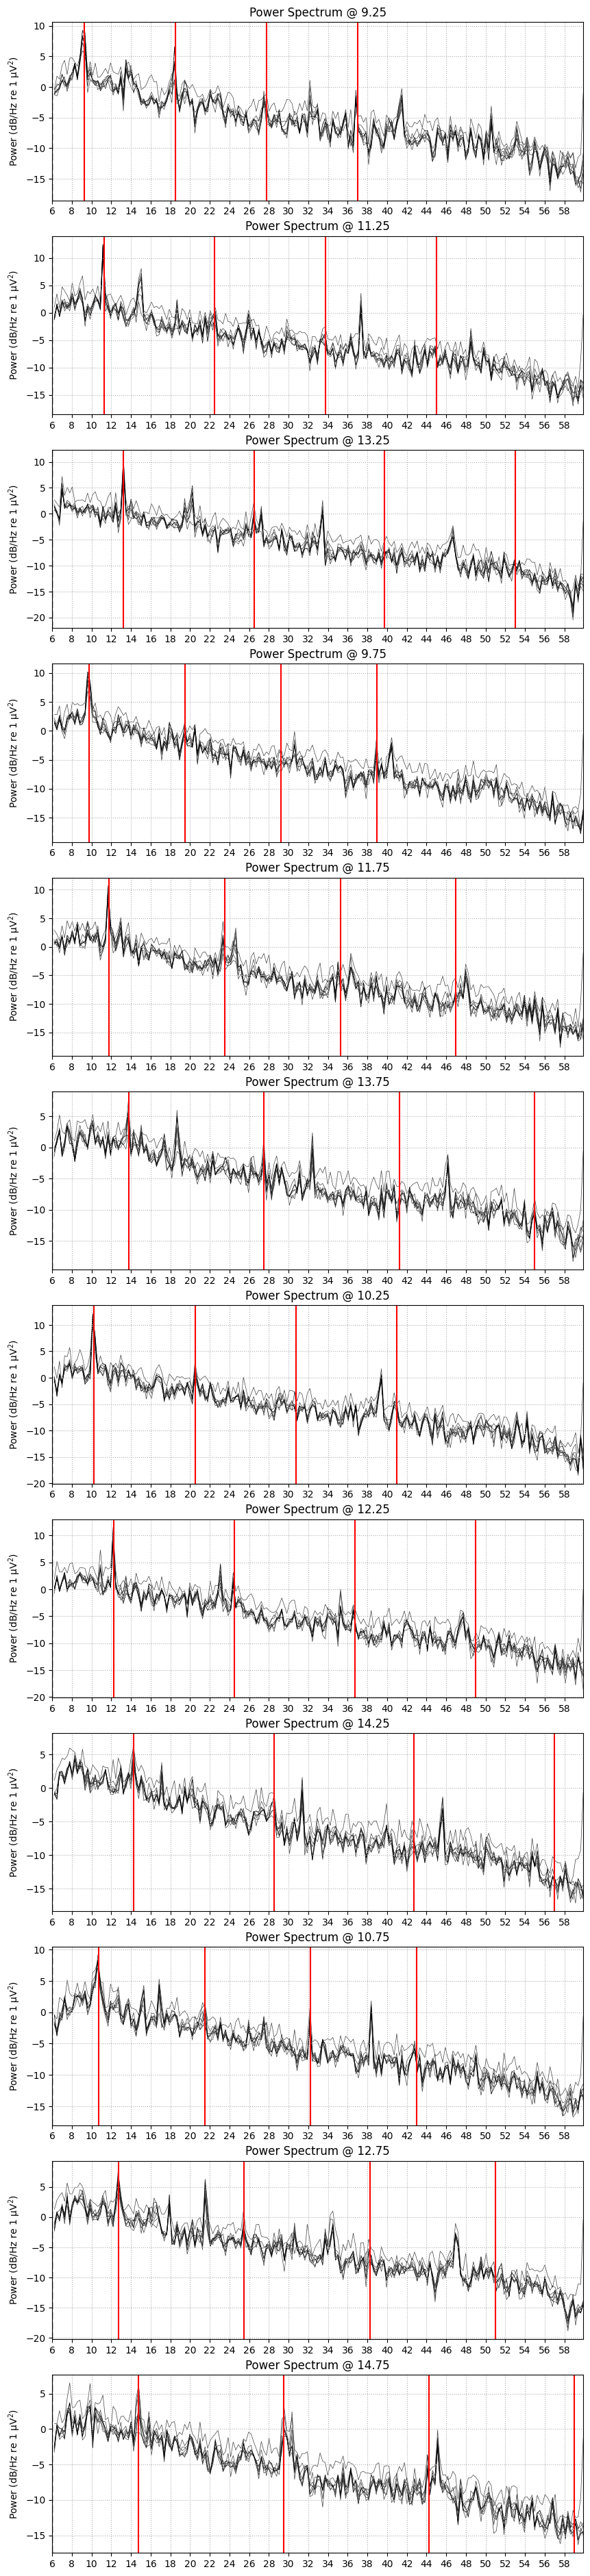

In [ ]:
fig, axes = plt.subplots(n_targets, 1, figsize=(10, 4 * n_targets))
for i in range(n_targets):
    mean_psd[i].plot(axes = axes[i])
    axes[i].set_title(f"Power Spectrum @ {target_freq[i]}")
    axes[i].set_xticks(np.arange(6, 60, 2))
    
    for k in range(5):
        axes[i].axvline(x = target_freq[i] * k, color = 'r', alpha = 0.5)